In [1]:
!pwd
!pip list

/workspace/CarND-Behavioral-Cloning-P3
DEPRECATION: The default format will switch to columns in the future. You can use --format=(legacy|columns) (or define a format=(legacy|columns) in your pip.conf under the [list] section) to disable this warning.
absl-py (0.7.0)
asn1crypto (0.24.0)
astor (0.7.1)
autograd (1.2)
backcall (0.1.0)
backports.shutil-get-terminal-size (1.0.0)
beautifulsoup4 (4.7.1)
bleach (3.0.2)
blessings (1.7)
bokeh (1.0.3)
bs4 (0.0.1)
cachetools (3.0.0)
certifi (2018.1.18)
cffi (1.11.5)
chardet (3.0.4)
Click (7.0)
cloudpickle (0.6.1)
cma (2.7.0)
conda (4.3.31)
cryptography (2.3)
cycler (0.10.0)
Cython (0.28.3)
dask (1.0.0)
decorator (4.3.0)
defusedxml (0.5.0)
distributed (1.25.2)
entrypoints (0.3)
future (0.17.1)
gast (0.2.2)
google-api-python-client (1.7.7)
google-auth (1.6.2)
google-auth-httplib2 (0.0.3)
google-auth-oauthlib (0.2.0)
gpustat (0.5.0)
grpcio (1.18.0)
h5py (2.9.0)
HeapDict (1.0.0)
html5lib (1.0.1)
httplib2 (0.12.0)
idna (2.6)
imageio (2.4.1)
imgaug (0.2

In [1]:
root_path = '../'
project_path = root_path + 'CarND-Behavioral-Cloning-P3/'
model_path = project_path + 'model/'
data_path = project_path + 'data/'

In [22]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
# from PIL import Image, ImageDraw
from moviepy.editor import VideoFileClip
import numpy as np
import pandas as pd
# import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf
import keras
from keras import backend as K
from keras import Input
from keras.models import Model
from keras.layers import Cropping2D, Conv2D, BatchNormalization
from keras.layers import ReLU, Flatten, Dense, Dropout, Lambda
# import cma
import sys
import os
import math
import glob
import csv

# Visualizations will be shown in the notebook.
%matplotlib inline

### Load training/testing/validation data

size: (20609, 7)


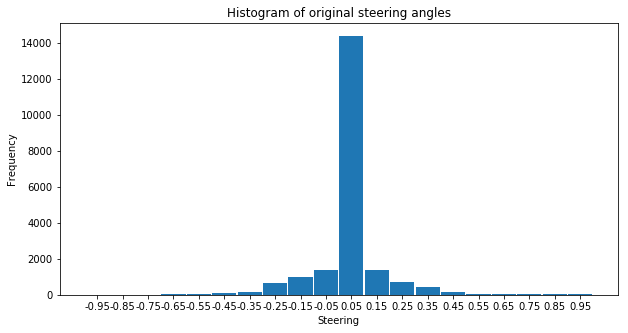

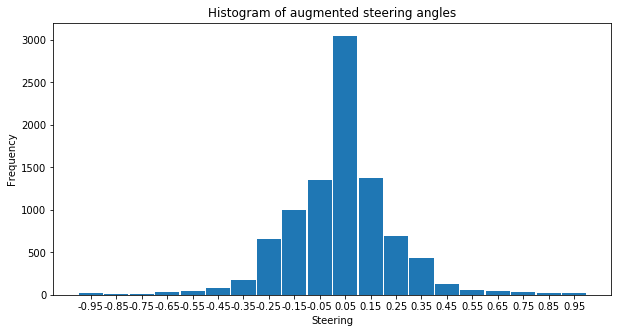

In [3]:
class DataList:
    def __init__(self, zero_frac=0.1):
        self.X_all = None
        self.y_all = None
        self.X_train = None
        self.y_train = None
        self.X_valid = None
        self.y_valid = None
        self.X_test = None
        self.y_test = None
        self.zero_frac = zero_frac
        self.original_df = self.read_csv()
        self.augmented_df = self.data_augmentation()

    def read_csv(self, folder=data_path):
        # Remove the space char at the beginning of the image file name 
        def strip(text):
            try:
                return text.strip()
            except AttributeError:
                return text

        def make_float(text):
            return float(text)

        df = pd.read_csv(folder + 'driving_log.csv',
                         sep=',',
                         converters = {'center': strip,
                                       'left': strip,
                                       'right': strip}
                        )
        print('size: {}'.format(df.shape))
        return df
    
    def merge_csv(self, auto_save=True):
        # Parse all subfolders under data/, except IMG
        folders = []
        for entry in os.scandir('data'):
            if entry.is_dir() and entry.path.find('.') < 0 and entry.name != 'IMG':
                folders.append(data_path + entry.name + '/')
        frames = [self.read_csv(folder) for folder in folders]
        df = pd.concat(frames)
        left = df['left'].apply(lambda x: x[x.find('IMG'):].replace('\\', '/'))
        right = df['right'].apply(lambda x: x[x.find('IMG'):].replace('\\', '/'))
        center = df['center'].apply(lambda x: x[x.find('IMG'):].replace('\\', '/'))
        df['left'] = left
        df['right'] = right
        df['center'] = center
        if auto_save:
            df.to_csv(path_or_buf='data/driving_log.csv', index=False,)
        print('total df size: {}'.format(df.shape))
        return df

    def data_augmentation(self, show_hist=True):
        df = self.original_df
        
        step = 0.1
        x_label = ['{:>.2f}'.format(x + step / 2) for x in np.arange(-1.0, 1.0, step).tolist()]
        if show_hist:
            # Show original data histogram
            # Group them by column 'steering' with step = 0.1
            groups = df.groupby(pd.cut(df["steering"], np.arange(-1.0, 1.0+step, step), labels=x_label))
            fig = plt.figure(1, figsize=(10, 5))
            rects = plt.bar(x_label, groups['steering'].count(), align="center", width=0.95)
            plt.title("Histogram of original steering angles")
            plt.xlabel("Steering")
            plt.ylabel("Frequency")
            plt.show()
            plt.close()
        
        # Filter panda DataFrame with condition 'steering = 0.0'
        # Only keep 10% of data whose 'steering = 0.0'
        zero_df = df[(df['steering'] < 1e-6) & (df['steering'] > -1e-6)]
        sample_zero_df = zero_df.sample(frac=self.zero_frac, random_state=None)
        not_zero_df = df[(df['steering'] >= 1e-6) | (df['steering'] <= -1e-6)]
        self.augmented_df = pd.concat([sample_zero_df, not_zero_df])
        # print('df shape: {}'.format(df.shape))
        # print('zero_df shape: {}'.format(zero_df.shape))
        # print('not_zero_df shape: {}'.format(not_zero_df.shape))
        # print('sample_zero_df shape: {}'.format(sample_zero_df.shape))
        # print('augmented_df shape: {}'.format(self.augmented_df.shape))
                
        if show_hist:
            # Show augmented data histogram
            # Group them by column 'steering' with step = 0.1
            groups = self.augmented_df.groupby(
                pd.cut(self.augmented_df["steering"],
                       np.arange(-1.0, 1.0+step, step),
                       labels=x_label))
            fig = plt.figure(1, figsize=(10, 5))
            rects = plt.bar(x_label, groups['steering'].count(), align="center", width=0.95)
            plt.title("Histogram of augmented steering angles")
            plt.xlabel("Steering")
            plt.ylabel("Frequency")
            plt.show()
            plt.close()

        df = self.augmented_df
        X = np.array(df['center'].tolist())
        left_X = np.array(df['left'].tolist())
        right_X = np.array(df['right'].tolist())
        y = np.array(df['steering'].tolist())
        left_y = self.steering_transform(np.array(df['steering'].tolist()), left=True)
        right_y = self.steering_transform(np.array(df['steering'].tolist()), left=False)
        self.X_all = np.concatenate((X, left_X, right_X))
        self.y_all = np.concatenate((y, left_y, right_y))
        X_train, X_test, y_train, y_test = train_test_split(self.X_all, self.y_all, test_size=0.3)
        X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5)
        self.X_train, self.X_test, self.X_valid = X_train, X_test, X_valid
        self.y_train, self.y_test, self.y_valid = y_train, y_test, y_valid
        # print('X_all: {}, y_all: {}'.format(self.X_all.shape, self.y_all.shape))
        # print('X_train: {}, y_train: {}'.format(self.X_train.shape, self.y_train.shape))
        # print('X_valid: {}, y_valid: {}'.format(self.X_valid.shape, self.y_valid.shape))
        # print('X_test: {}, y_test: {}'.format(self.X_test.shape, self.y_test.shape))

    def steering_transform(self, y, left=True):
        correction = 0.2
        if left == True:
            y += correction
        else:
            y -= correction
        return y

data_list = DataList(zero_frac=0.15)
# df = data_list.merge_csv()
# df = data_list.read_csv()
# df.head()

### Generator
Here is an example of how you could use a generator to load data and preprocess it on the fly, in batch size portions to feed into your Behavioral Cloning model.

In [4]:
def generator(X, y, batch_size=32, flipped=True):
    if flipped == True:
        X_flip = np.copy(X)
        y_flip = np.copy(y) * -1
        zero_tag = np.zeros_like(y, dtype=np.int8)
        one_tag = np.ones_like(y, dtype=np.int8)
        y_flip_tag = np.concatenate((zero_tag, one_tag))
        X = np.concatenate((X, X))
        y = np.concatenate((y, y_flip))
    else:
        y_flip_tag = np.zeros_like(y, dtype=np.int8)
    data_size = X.shape[0]
        
    while 1: # Loop forever so the generator never terminates
        X, y, y_flip_tag = shuffle(X, y, y_flip_tag)
        for offset in range(0, data_size, batch_size):
            X_batch = X[offset:offset+batch_size]
            flip_tag_batch = y_flip_tag[offset:offset+batch_size]

            images = []
            for name, flip in zip(X_batch, flip_tag_batch):
                # print('name: {}'.format(name))
                # print('Read image: {}'.format(data_path + name))
                img = mpimg.imread(data_path + name)
                if flip == 1:
                    img = np.fliplr(img)
                images.append(img)
                
            # trim image to only see section with road
            X_train = np.array(images)
            y_train = y[offset:offset+batch_size]
            # TODO: Do some image augmentation here.
            # yield sklearn.utils.shuffle(X_train, y_train)
            yield X_train, y_train

### Verify generator

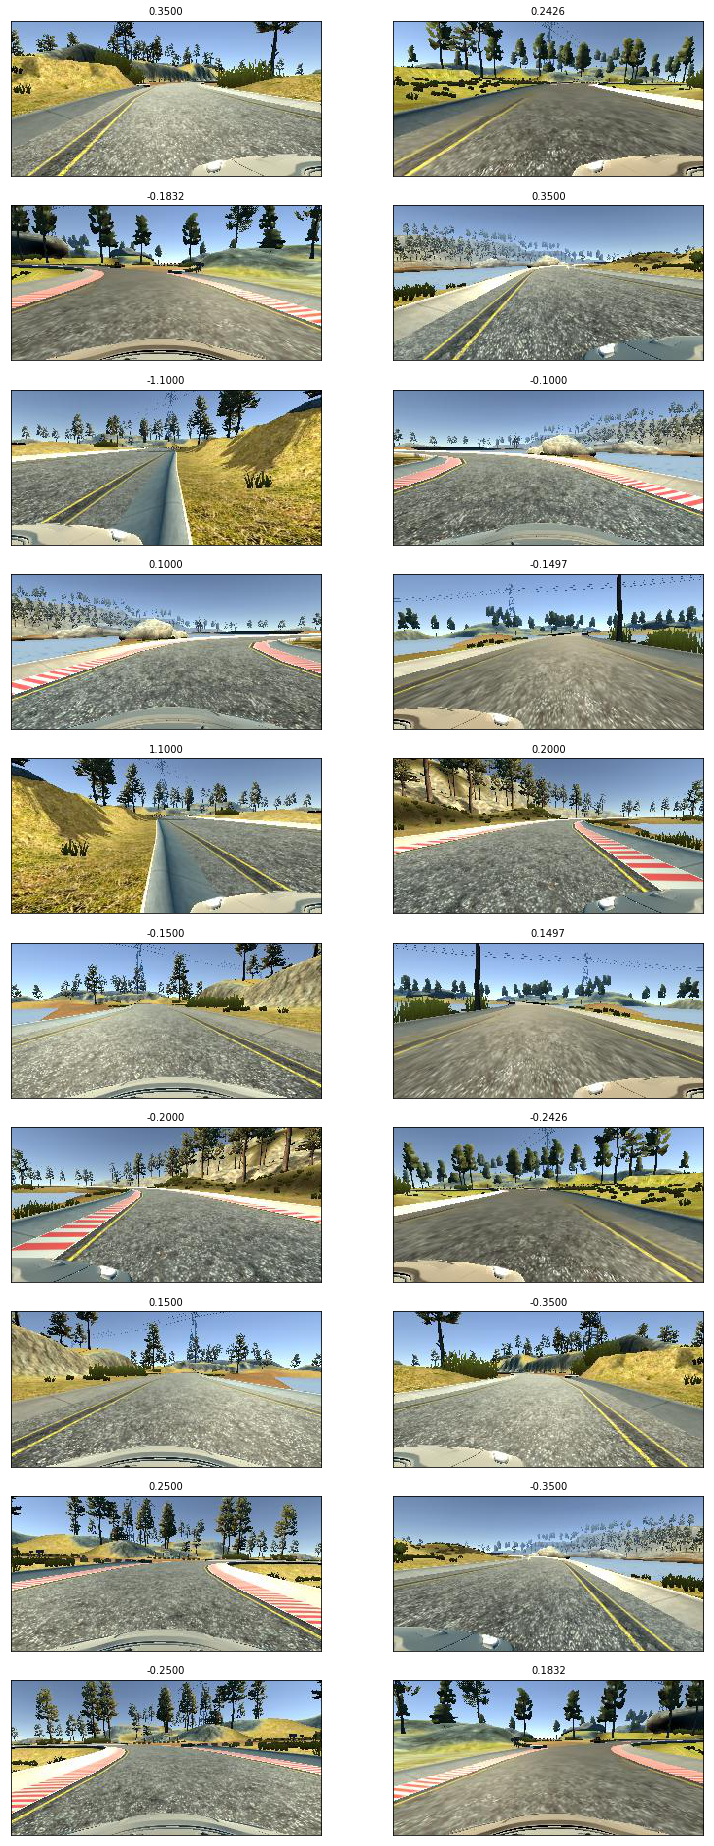

In [9]:
idx_rand = np.random.choice(data_list.X_train.shape[0], size=10)
X_random = data_list.X_train[idx_rand]
y_random = data_list.y_train[idx_rand]

generator_1 = generator(X_random, y_random, batch_size=2)
step_1 = math.ceil(X_random.shape[0] * 2 / 2)

f, axis = plt.subplots(step_1, 2, figsize=(10, 28))
f.tight_layout()
for row in range(step_1):
    col = 0
    image, steer = next(generator_1)
    axis[row][col].imshow(image[0].astype(np.uint8))
    axis[row][col+1].imshow(image[1].astype(np.uint8))
    axis[row][col].set_title('{:>.4f}'.format(steer[0]), fontsize=10)
    axis[row][col+1].set_title('{:>.4f}'.format(steer[1]), fontsize=10)
    axis[row][col].get_xaxis().set_visible(False)
    axis[row][col].get_yaxis().set_visible(False)
    axis[row][col+1].get_xaxis().set_visible(False)
    axis[row][col+1].get_yaxis().set_visible(False)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()
plt.close()

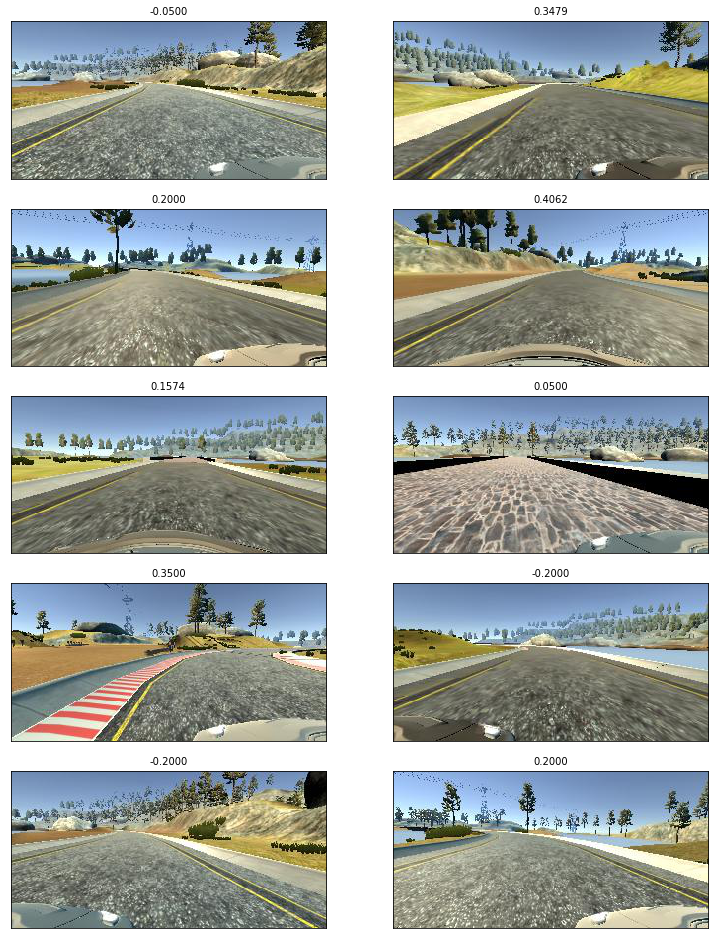

In [8]:
idx_rand = np.random.choice(data_list.X_train.shape[0], size=10)
X_random = data_list.X_train[idx_rand]
y_random = data_list.y_train[idx_rand]

generator_2 = generator(X_random, y_random, batch_size=2, flipped=False)
step_2 = math.ceil(X_random.shape[0] / 2)

f, axis = plt.subplots(step_2, 2, figsize=(10, 14))
f.tight_layout()
for row in range(step_2):
    col = 0
    image, steer = next(generator_2)
    axis[row][col].imshow(image[0].astype(np.uint8))
    axis[row][col+1].imshow(image[1].astype(np.uint8))
    axis[row][col].set_title('{:>.4f}'.format(steer[0]), fontsize=10)
    axis[row][col+1].set_title('{:>.4f}'.format(steer[1]), fontsize=10)
    axis[row][col].get_xaxis().set_visible(False)
    axis[row][col].get_yaxis().set_visible(False)
    axis[row][col+1].get_xaxis().set_visible(False)
    axis[row][col+1].get_yaxis().set_visible(False)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()
plt.close()

### Using Keras to build PilotNet

![PilotNet](https://i0.wp.com/syncedreview.com/wp-content/uploads/2017/05/screen-shot-2017-05-12-at-11-25-28-pm.png?resize=950%2C869&ssl=1)

The convolutional layers were designed to perform feature extraction and were chosen empirically through a series of experiments that varied layer configurations. We use strided convolutions in the first three convolutional layers with a 2x2 stride and a 5x5 kernel and a non-strided convolution with a 3x3 kernel size in the last two convolutional layers.

In [5]:
class PilotNet:
    def __init__(self):
        self.model = None
        self.salient_model = None
        self.cropping_top = 50
        self.cropping_down = 20
        
    def build_model(self):
        self.build_pilotnet_model()
        self.build_salient_model()
        
    def build_pilotnet_model(self):
        def resize(images):
            import tensorflow as tf
            return tf.image.resize_area(images, size=(66, 200))
        
        def preprocessing(images):
            import tensorflow as tf
            return tf.map_fn(lambda img: tf.image.per_image_standardization(img), images)
        
        cropping_top, cropping_down = self.cropping_top, self.cropping_down

        # Build PilotNet model
        inputs = keras.Input(shape=(160, 320, 3), name='inputs')
        cropping = keras.layers.Cropping2D(cropping=((cropping_top, cropping_down), (0, 0)),
                                           name='cropping')(inputs)
        resize = keras.layers.Lambda(resize, name='resize')(cropping)
        norm = keras.layers.Lambda(preprocessing, name='normalization')(resize)
        # input = (66, 200, 3), output = (31, 98, 24)
        conv_1 = keras.layers.Conv2D(filters=24,
                                     kernel_size=5,
                                     strides=2,
                                     padding='valid',
                                     name='conv_1')(norm)
        bn_1 = keras.layers.BatchNormalization(name='bn_1')(conv_1)
        relu_1 = keras.layers.ReLU(name='relu_1')(bn_1)
        
        # input = (31, 98, 24), output = (14, 47, 36)
        conv_2 = keras.layers.Conv2D(filters=36,
                                     kernel_size=5,
                                     strides=2,
                                     padding='valid',
                                     name='conv_2')(relu_1)
        bn_2 = keras.layers.BatchNormalization(name='bn_2')(conv_2)
        relu_2 = keras.layers.ReLU(name='relu_2')(bn_2)
        
        # input = (14, 47, 36), output = (5, 22, 48)
        conv_3 = keras.layers.Conv2D(filters=48,
                                     kernel_size=5,
                                     strides=2,
                                     padding='valid',
                                     name='conv_3')(relu_2)
        bn_3 = keras.layers.BatchNormalization(name='bn_3')(conv_3)
        relu_3 = keras.layers.ReLU(name='relu_3')(bn_3)
        
        # input = (5, 22, 48), output = (3, 20, 64)
        conv_4 = keras.layers.Conv2D(filters=64,
                                     kernel_size=3,
                                     strides=1,
                                     padding='valid',
                                     name='conv_4')(relu_3)
        bn_4 = keras.layers.BatchNormalization(name='bn_4')(conv_4)
        relu_4 = keras.layers.ReLU(name='relu_4')(bn_4)
        
        # input = (3, 20, 64), output = (1, 18, 64)
        conv_5 = keras.layers.Conv2D(filters=64,
                                     kernel_size=3,
                                     strides=1,
                                     padding='valid',
                                     name='conv_5')(relu_4)
        bn_5 = keras.layers.BatchNormalization(name='bn_5')(conv_5)
        relu_5 = keras.layers.ReLU(name='relu_5')(bn_5)
        
        # input = (1, 18, 64), output = (1152,)
        flatten = keras.layers.Flatten(name='flatten')(relu_5)
        
        # input = (1152,), output = (100,)
        dense_6 = keras.layers.Dense(units=100,
                                     name='dense_6')(flatten)
        bn_6 = keras.layers.BatchNormalization(name='bn_6')(dense_6)
        relu_6 = keras.layers.ReLU(name='relu_6')(bn_6)
        dropout_6 = keras.layers.Dropout(rate=0.5, name='dropout_6')(relu_6)
        
        # input = (100,), output = (50,)
        dense_7 = keras.layers.Dense(units=50,
                                     name='dense_7')(dropout_6)
        bn_7 = keras.layers.BatchNormalization(name='bn_7')(dense_7)
        relu_7 = keras.layers.ReLU(name='relu_7')(bn_7)
        dropout_7 = keras.layers.Dropout(rate=0.5, name='dropout_7')(relu_7)
        
        # input = (50,), output = (10,)
        dense_8 = keras.layers.Dense(units=10,
                                     name='dense_8')(dropout_7)
        bn_8 = keras.layers.BatchNormalization(name='bn_8')(dense_8)
        relu_8 = keras.layers.ReLU(name='relu_8')(bn_8)
        dropout_8 = keras.layers.Dropout(rate=0.5, name='dropout_8')(relu_8)
        
        # input = (10,), output = (1,)
        outputs = keras.layers.Dense(units=1,
                                     name='outputs')(dropout_8)


        # set up cropping2D layer
        self.model = keras.Model(inputs=inputs, outputs=outputs)
        self.model.compile(optimizer=keras.optimizers.Adam(0.01),
                           loss=keras.losses.logcosh,
                           # loss='mse',
                           metrics=['mse', 'mae'])
        
    def build_salient_model(self):
        def resize_norm(images):
            import tensorflow as tf
            resize = tf.image.resize_area(images, size=(90, 320))
            max_val = tf.math.reduce_max(resize)
            return tf.math.divide(resize, max_val)
        
        # Build salient model
        relu_5 = self.model.get_layer('relu_5').output
        relu_4 = self.model.get_layer('relu_4').output
        relu_3 = self.model.get_layer('relu_3').output
        relu_2 = self.model.get_layer('relu_2').output
        relu_1 = self.model.get_layer('relu_1').output
        
        ave_5 = keras.layers.Lambda(lambda x: K.mean(x, axis=3, keepdims=True), name='ave_5')(relu_5)
        deconv_5 = keras.layers.Conv2DTranspose(filters=1,
                                                kernel_size=3,
                                                strides=1,
                                                padding='valid',
                                                output_padding=(0, 0),
                                                use_bias=False,
                                                kernel_initializer=keras.initializers.Ones(),
                                                name='deconv_5')(ave_5)
        
        ave_4 = keras.layers.Lambda(lambda x: K.mean(x, axis=3, keepdims=True), name='ave_4')(relu_4)
        mul_4 = keras.layers.Multiply(name='mul_4')([ave_4, deconv_5])
        deconv_4 = keras.layers.Conv2DTranspose(filters=1,
                                                kernel_size=3,
                                                strides=1,
                                                padding='valid',
                                                output_padding=(0, 0),
                                                use_bias=False,
                                                kernel_initializer=keras.initializers.Ones(),
                                                name='deconv_4')(mul_4)
        
        ave_3 = keras.layers.Lambda(lambda x: K.mean(x, axis=3, keepdims=True), name='ave_3')(relu_3)
        mul_3 = keras.layers.Multiply(name='mul_3')([ave_3, deconv_4])
        deconv_3 = keras.layers.Conv2DTranspose(filters=1,
                                                kernel_size=5,
                                                strides=2,
                                                padding='valid',
                                                output_padding=(1, 0),
                                                use_bias=False,
                                                kernel_initializer=keras.initializers.Ones(),
                                                name='deconv_3')(mul_3)
        
        ave_2 = keras.layers.Lambda(lambda x: K.mean(x, axis=3, keepdims=True), name='ave_2')(relu_2)
        mul_2 = keras.layers.Multiply(name='mul_2')([ave_2, deconv_3])
        deconv_2 = keras.layers.Conv2DTranspose(filters=1,
                                                kernel_size=5,
                                                strides=2,
                                                padding='valid',
                                                output_padding=(0, 1),
                                                use_bias=False,
                                                kernel_initializer=keras.initializers.Ones(),
                                                name='deconv_2')(mul_2)
        
        ave_1 = keras.layers.Lambda(lambda x: K.mean(x, axis=3, keepdims=True), name='ave_1')(relu_1)
        mul_1 = keras.layers.Multiply(name='mul_1')([ave_1, deconv_2])
        deconv_1 = keras.layers.Conv2DTranspose(filters=1,
                                                kernel_size=5,
                                                strides=2,
                                                padding='valid',
                                                output_padding=(1, 1),
                                                use_bias=False,
                                                kernel_initializer=keras.initializers.Ones(),
                                                name='deconv_1')(mul_1)
        salient_mask = keras.layers.Lambda(resize_norm, name='salient_mask')(deconv_1)
        
        self.salient_model = keras.Model(inputs=self.model.input, outputs=salient_mask)
        self.salient_model.compile(optimizer=keras.optimizers.Adam(0.01),
                                   loss='mse', metrics=['mse'])
        
        return self.salient_model
        
    def predict_generator(self, generator, steps):
        result = self.model.predict_generator(generator=generator, steps=steps)
        return result
    
    def train(self, train_generator, train_steps, epochs, verbose,
              valid_generator, valid_step):
        history = self.model.fit_generator(
            generator=train_generator,
            steps_per_epoch=train_steps,
            epochs=epochs,
            verbose=verbose,
            validation_data=valid_generator,
            validation_steps=valid_step)
        return history
    
    def get_salient_image(self, generator, steps):
        top = self.cropping_top
        salient_images = []
        mask_color = [14, 252, 26]
        for i in range(steps):
            images, steers = next(generator)
            mask = self.salient_model.predict(images)
            mask = np.tile(mask, 3)
            mask[:,:,:,0] *= mask_color[0]
            mask[:,:,:,1] *= mask_color[1]
            mask[:,:,:,2] *= mask_color[2]
            full_mask = np.zeros_like(images)
            full_mask[:,top:top+mask.shape[1],:,:] = mask
            for i in range(full_mask.shape[0]):
                salient_img = cv2.addWeighted(images[i], 1.0, full_mask[i], 0.8, 0)
                salient_images.append(salient_img)
        return salient_images
    
    def save_model(self, name, model_type='entire'):
        if name.endswith('h5') == False:
            name += '.h5'
        if model_type == 'weight':
            self.model.save_weights(name)
        elif model_type == 'entire':
            self.model.save(name)
        
    def load_model(self, name, model_type='entire'):
        if model_type == 'weight':
            # Restore the model's state,
            # this requires a model with the same architecture.
            if self.model == None:
                self.build_model()
            self.model.load_weights(name)
        elif model_type == 'entire':
            # Recreate the exact same model, including weights and optimizer.
            self.model = keras.models.load_model(name)
            self.build_salient_model()
    
pilot_net = PilotNet()
pilot_net.build_model()
# pilot_net.build_salient_model()

### Output model structure image

In [6]:
tf.keras.utils.plot_model(
    pilot_net.model,
    to_file='pilot_net.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB'
)

tf.keras.utils.plot_model(
    pilot_net.salient_model,
    to_file='salient_net.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB'
)

### Start training

In [14]:
# Set generator batch size
batch_size = 64
# compile and train the model using the generator function
train_generator = generator(data_list.X_train, data_list.y_train, batch_size=batch_size)
test_generator = generator(data_list.X_test, data_list.y_test, batch_size=batch_size)
valid_generator = generator(data_list.X_valid, data_list.y_valid, batch_size=batch_size)
train_step = math.ceil(data_list.X_train.shape[0] * 2 / batch_size)
test_step = math.ceil(data_list.X_test.shape[0] * 2 / batch_size)
valid_step = math.ceil(data_list.X_valid.shape[0] * 2 / batch_size)

epochs = 100
verbose = 1
history = pilot_net.train(train_generator, train_step, epochs, verbose, valid_generator, valid_step)

Epoch 1/100
610/610 [==============================] - 202s 331ms/step - loss: 0.0369 - mean_squared_error: 0.0828 - mean_absolute_error: 0.2038 - val_loss: 0.0222 - val_mean_squared_error: 0.0461 - val_mean_absolute_error: 0.1613
Epoch 2/100
610/610 [==============================] - 186s 305ms/step - loss: 0.0244 - mean_squared_error: 0.0507 - mean_absolute_error: 0.1696 - val_loss: 0.0187 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1458
Epoch 3/100
610/610 [==============================] - 180s 295ms/step - loss: 0.0226 - mean_squared_error: 0.0469 - mean_absolute_error: 0.1625 - val_loss: 0.0173 - val_mean_squared_error: 0.0357 - val_mean_absolute_error: 0.1393
Epoch 4/100
610/610 [==============================] - 192s 316ms/step - loss: 0.0217 - mean_squared_error: 0.0450 - mean_absolute_error: 0.1591 - val_loss: 0.0165 - val_mean_squared_error: 0.0341 - val_mean_absolute_error: 0.1366
Epoch 5/100
610/610 [==============================] - 189s 309ms/step - los

610/610 [==============================] - 186s 305ms/step - loss: 0.0132 - mean_squared_error: 0.0270 - mean_absolute_error: 0.1217 - val_loss: 0.0106 - val_mean_squared_error: 0.0216 - val_mean_absolute_error: 0.1089
Epoch 37/100
610/610 [==============================] - 185s 304ms/step - loss: 0.0131 - mean_squared_error: 0.0270 - mean_absolute_error: 0.1217 - val_loss: 0.0129 - val_mean_squared_error: 0.0264 - val_mean_absolute_error: 0.1211
Epoch 38/100
610/610 [==============================] - 176s 288ms/step - loss: 0.0129 - mean_squared_error: 0.0264 - mean_absolute_error: 0.1202 - val_loss: 0.0117 - val_mean_squared_error: 0.0238 - val_mean_absolute_error: 0.1148
Epoch 39/100
610/610 [==============================] - 185s 304ms/step - loss: 0.0125 - mean_squared_error: 0.0256 - mean_absolute_error: 0.1190 - val_loss: 0.0128 - val_mean_squared_error: 0.0261 - val_mean_absolute_error: 0.1201
Epoch 40/100
610/610 [==============================] - 186s 305ms/step - loss: 0.012

610/610 [==============================] - 183s 301ms/step - loss: 0.0108 - mean_squared_error: 0.0220 - mean_absolute_error: 0.1083 - val_loss: 0.0140 - val_mean_squared_error: 0.0286 - val_mean_absolute_error: 0.1265
Epoch 72/100
610/610 [==============================] - 178s 292ms/step - loss: 0.0111 - mean_squared_error: 0.0226 - mean_absolute_error: 0.1094 - val_loss: 0.0109 - val_mean_squared_error: 0.0223 - val_mean_absolute_error: 0.1112
Epoch 73/100
610/610 [==============================] - 187s 306ms/step - loss: 0.0109 - mean_squared_error: 0.0223 - mean_absolute_error: 0.1086 - val_loss: 0.0108 - val_mean_squared_error: 0.0220 - val_mean_absolute_error: 0.1096
Epoch 74/100
610/610 [==============================] - 183s 300ms/step - loss: 0.0109 - mean_squared_error: 0.0222 - mean_absolute_error: 0.1087 - val_loss: 0.0111 - val_mean_squared_error: 0.0227 - val_mean_absolute_error: 0.1108
Epoch 75/100
610/610 [==============================] - 177s 291ms/step - loss: 0.010

In [27]:
file_name = model_path + 'logcosh_epoch_100_frac_0.15'
pilot_net.save_model(file_name, model_type='entire')

### Finding the Salient Objects
![Salient image 01](./images/salient_image_01.png)
![Salient image 02](./images/salient_image_02.png)
![VisualBackProp](./images/VisualBackProp.png)

In [7]:
file_name = model_path + 'logcosh_epoch_100_frac_0.15.h5'
pilot_net.load_model(file_name)

In [11]:
weight_name = model_path + 'model_weight.h5'
pilot_net.save_model(weight_name, model_type='weight')

In [19]:
sample_size = 10
idx_rand = np.random.choice(data_list.X_test.shape[0], size=sample_size)
X_random = data_list.X_test[idx_rand]
y_random = data_list.y_test[idx_rand]

In [20]:
batch_size = 1
generator_3 = generator(X_random, y_random, batch_size=batch_size, flipped=False)
step_3 = math.ceil(X_random.shape[0] / batch_size)
# result = pilot_net.predict_generator(generator_3, step_3)
# print('result: {}'.format(result))

salient_output = pilot_net.get_salient_image(generator_3, step_3)

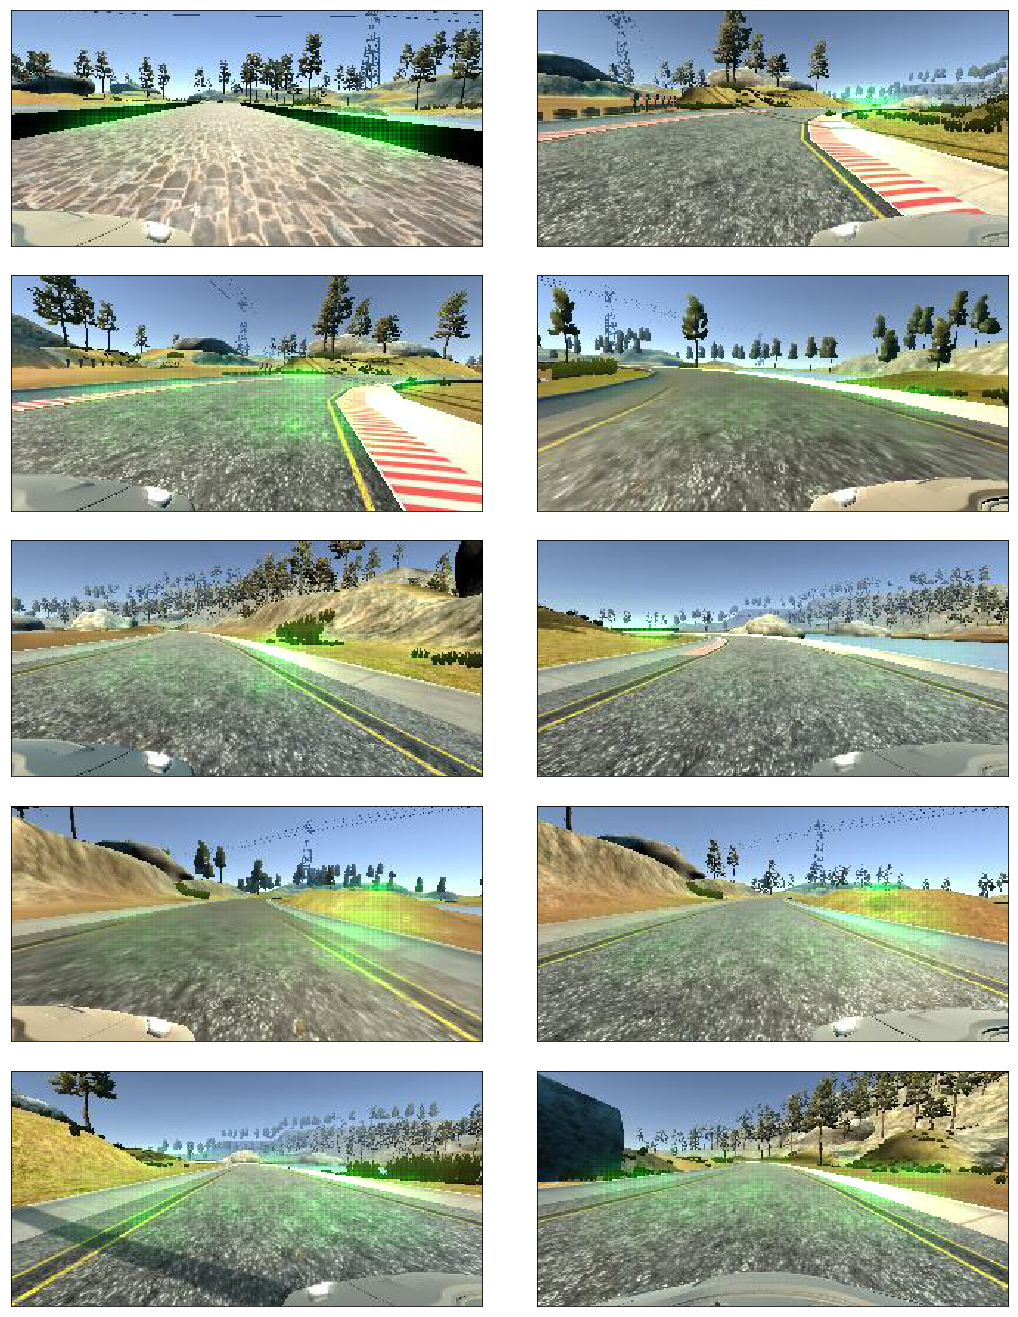

In [21]:
rows = int(len(salient_output) / 2)
f, axis = plt.subplots(rows, 2, figsize=(14, 20))
f.tight_layout()
idx = 0
col = 0
for row in range(rows):
    axis[row][col].imshow(salient_output[idx * 2])
    axis[row][col+1].imshow(salient_output[idx * 2 + 1])
    axis[row][col].get_xaxis().set_visible(False)
    axis[row][col].get_yaxis().set_visible(False)
    axis[row][col+1].get_xaxis().set_visible(False)
    axis[row][col+1].get_yaxis().set_visible(False)
    idx += 1

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()
plt.close()

In [ ]:
video_name = "project_video.mp4"
# video_name = 'challenge_video.mp4'
# video_name = 'harder_challenge_video.mp4'
white_output = "output_videos/" + video_name
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip1 = VideoFileClip(video_name).set_fps(1).subclip(0, 3)
# clip1 = VideoFileClip(video_name).set_fps(1)
# clip1 = VideoFileClip(video_name).subclip(35, 40)
# clip1 = VideoFileClip(video_name).subclip(0, 5)
clip1 = VideoFileClip(video_name)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

video_name_1 = "output_videos/project_video.mp4"
video_name_2 = "output_videos/challenge_video.mp4"
# video_name = 'challenge_video.mp4'
# video_name = 'harder_challenge_video.mp4'
clip1 = VideoFileClip(video_name_1)
clip2 = VideoFileClip(video_name_2)
# white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
# %time white_clip.write_videofile(white_output, audio=False)

gif_clip_1 = clip1.subclip(20, 25)
gif_clip_2 = clip2.subclip(0, 4)
gif_clip_1.speedx(2).to_gif('output_videos/project_video_20_25.gif')
gif_clip_2.speedx(2).to_gif('output_videos/challenge_video_00_04.gif')

In [ ]:
from moviepy.editor import ImageSequenceClip
#Installation instructions: 
#    pip install numpy
#    pip install moviepy
#    Moviepy needs ffmpeg tools on your system
#        (I got mine with opencv2 installed with ffmpeg support)

def create_gif(filename, array, fps=10, scale=1.0):
    """creates a gif given a stack of ndarray using moviepy
    Parameters
    ----------
    filename : string
        The filename of the gif to write to
    array : array_like
        A numpy array that contains a sequence of images
    fps : int
        frames per second (default: 10)
    scale : float
        how much to rescale each image by (default: 1.0)
    """
    fname, _ = os.path.splitext(filename)   #split the extension by last period
    filename = fname + '.gif'               #ensure the .gif extension
    if array.ndim == 3:                     #If number of dimensions are 3, 
        array = array[..., np.newaxis] * np.ones(3)   #copy into the color 
                                                      #dimension if images are 
                                                      #black and white
    clip = ImageSequenceClip(list(array), fps=fps).resize(scale)
    clip.write_gif(filename, fps=fps)
    return clip

randomimage = np.random.randn(100, 64, 64)       
create_gif('test.gif', randomimage)                 #example 1

myimage = np.ones(shape=(300, 200))
myimage[:] = 25
myimage2 = np.ones(shape=(300, 200))
myimage2[:] = 85
arrayOfNdarray = np.array([myimage, myimage2])

create_gif(filename="grey_then_black.gif",          #example 2
           array=arrayOfNdarray, 
           fps=5, 
           scale=1.3)

In [25]:
class SimpleDataList:
    def __init__(self):
        self.X_train = None
        self.y_train = None
        self.original_df = self.read_csv()

    def read_csv(self, folder=data_path):
        # Remove the space char at the beginning of the image file name 
        def strip(text):
            try:
                return text.strip()
            except AttributeError:
                return text

        def make_float(text):
            return float(text)

        df = pd.read_csv(folder + 'driving_log.csv',
                         sep=',',
                         converters = {'center': strip,
                                       'left': strip,
                                       'right': strip}
                        )
        print('size: {}'.format(df.shape))
        return df

    def data_augmentation(self, show_hist=True):
        df = self.original_df
        self.X_train = np.array(df['center'].tolist())
        self.y_train = np.array(df['steering'].tolist())

size: (1240, 7)


In [26]:
def simple_generator(X, y, batch_size=1, flipped=False):
    if flipped == True:
        X_flip = np.copy(X)
        y_flip = np.copy(y) * -1
        zero_tag = np.zeros_like(y, dtype=np.int8)
        one_tag = np.ones_like(y, dtype=np.int8)
        y_flip_tag = np.concatenate((zero_tag, one_tag))
        X = np.concatenate((X, X))
        y = np.concatenate((y, y_flip))
    else:
        y_flip_tag = np.zeros_like(y, dtype=np.int8)
    data_size = X.shape[0]
        
    while 1: # Loop forever so the generator never terminates
        # X, y, y_flip_tag = shuffle(X, y, y_flip_tag)
        for offset in range(0, data_size, batch_size):
            X_batch = X[offset:offset+batch_size]
            flip_tag_batch = y_flip_tag[offset:offset+batch_size]

            images = []
            for name, flip in zip(X_batch, flip_tag_batch):
                # print('name: {}'.format(name))
                # print('Read image: {}'.format(data_path + name))
                img = mpimg.imread(data_path + name)
                if flip == 1:
                    img = np.fliplr(img)
                images.append(img)
                
            # trim image to only see section with road
            X_train = np.array(images)
            y_train = y[offset:offset+batch_size]
            # TODO: Do some image augmentation here.
            # yield sklearn.utils.shuffle(X_train, y_train)
            yield X_train, y_train

In [30]:
import moviepy.editor as mpy

simple_data_list = SimpleDataList()
simple_data_list.data_augmentation()
gif_generator = simple_generator(simple_data_list.X_train, simple_data_list.y_train)
gif_step = simple_data_list.X_train.shape[0]
salient_output = pilot_net.get_salient_image(gif_generator, gif_step)
print('salient_output complete')

size: (1240, 7)
salient_output complete


In [34]:
gif_name = project_path + 'images/salient_object'
fps = 30
# file_list = glob.glob('*.png') # Get all the pngs in the current directory
# list.sort(file_list, key=lambda x: int(x.split('_')[1].split('.png')[0])) # Sort the images by #, this may need to be tweaked for your use case
clip = mpy.ImageSequenceClip(salient_output, fps=fps)
# clip.write_videofile(gif_name + ".mp4",fps=fps)
%time clip.write_gif('{}.gif'.format(gif_name), fps=fps)

AttributeError: type object 'tqdm' has no attribute '_lock'

### Show history

In [18]:
for key in history.history.keys():
    print('Key of history: {}'.format(key))

Key of history: val_loss
Key of history: val_mean_squared_error
Key of history: val_mean_absolute_error
Key of history: loss
Key of history: mean_squared_error
Key of history: mean_absolute_error


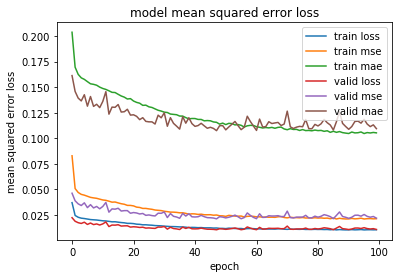

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_mean_squared_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'train mse', 'train mae',
            'valid loss', 'valid mse', 'valid mae'], loc='upper right')
plt.show()
plt.close()